# Simulating an Exactly-Solvable Nuclear Model with Quantum Computing

## Summary
This example code will generate the quantum circuits necessary to prepare any eigenstate of the Lipkin-Meshkov-Glick (LMG) model. It will then run these circuits on a noiseless quantum computing simulator and analyze the measured results to produce an estimate of the expectation value of the LMG Hamiltonian $\langle H\rangle$.

Because the LMG model is exactly solvable, we can efficiently create and diagonalize the LMG Hamiltonian for its eigensystem. We can then take an eigenstate and prepare it directly with a specialized quantum circuit. Afterwards, we make measurements on the resultant states and use them to estimate $\langle H\rangle$. Finally we can compare the estimated expectation value with the previously-calculated eigenstate.

Due to sampling variation, this code should produce an estimate within one standard error of the expected mean on the order of $70\%$ of the time.

### Similarities to VQE








## Packages and Setup
We have already constructed all of the relevant functions. We must import them.

In [1]:
import numpy as np
from lmg import total_circuit_runner, state_prep
from analyzer import distrfinder
from state_generator import state_finder_fock, angle_finder
import dwave.gate.simulator
import random as ra
import matplotlib.pyplot as plt

## Defining a State to Simulate

There are several variables which the user can define to describe a physical model.

* $M$ is a positive integer. It defines how many particle pairs are being simulated and is equal to the number of qubits to be used in the circuits.
* $V$ is a nonzero real number. It represents the strength of a particular interaction in the model.
* $W$ is a real number such that $|W|<|V|$. It represents the strength of a particular interaction in the model.
* $\nu_a$ (`nua`) is either $0$ or $1$. It represents an unpaired particle in the "a" mode of the LMG model.
* $\nu_b$ (`nub`) is either $0$ or $1$. It represents an unpaired particle in the "b" mode of the LMG model.
* `energy_level` is a positive integer between $0$ to $M-1$ (inclusively). It represents which energy state we will prepare with our quantum circuits. Setting `energy_level=0` will prepare the ground state while setting `energy_level=1` will prepare the first excited state and so on.

In [2]:
'''
By default we pick M, V, W, nua, nub and energy_level randomly
You can replace them with your own values instead!
'''
M = ra.randint(1,10)
V = ra.uniform(-10,10)
W = V * ra.uniform(-0.99,0.99)
nua = ra.randint(0,1)
nub = ra.randint(0,1)
energy_level = ra.randint(0,M-1)
targ_val,targ_state = state_finder_fock(M,V,W,nua,nub,energy_level)
print(f'The target expectation value is <H> = {np.round(targ_val,4)}')

The target expectation value is <H> = -5.9393


## Finding the Ansatz Parameters

This demo uses a specialized ansatz circuit which is capable of preparing any eigenstate of the LMG model. It is also possible to solve for the ansatz parameters $\{\theta_1,...,\theta_M\}$ ahead of time to directly prepare the target state.

The `angle_finder()` function takes in the target LMG eigenstate we wish to prepare. It then calculates the specific ansatz parameters so that our special ansatz circuit can prepare the target eigenstate.

In [3]:
ansatz_parameters=angle_finder(targ_state)

## Preparing the Circuits, Simulating Them and Measuring

Now that we have the ansatz parameters, we can construct our circuits. In this step we shall employ "parallel measurement;" a technique which leverages features of quantum mechanics to condense the measurable quantities ("Paulis") into groups ("cliques") which can be measured simultaneously. This reduces the number of circuits that have to be run.

For a generic chemical problem, the number of cliques rises polynomially with the number of particles simulated FIX CITE. For the LMG model in this encoding, we can always configure the Paulis into at most four cliques FIX CITE.

The `total_circuit_runner()` function takes in the ansatz parameters as well as the number of shots we want to run and a file name to write the measurement bitstrings to. When called, `total_circuit_runner()` prepares all the quantum circuits, simulates each of them `shots` times, measures the qubits and saves the bitstrings to an external file.

In [4]:
shots = 10**4
total_circuit_runner(ansatz_parameters,'test_dest',shots)
print('Simulation complete!')

Simulation complete!


## Analyzing the Measurements

We now have measured bitstrings, sorted in chronological order, for each circuit we had to run. This is stored in the file written in the `total_circuit_runner()` function. We now have to read these bitstrings and interpret them as contributions to our estimate of the Hamiltonian expectation value.

To do so we shall proceed according to FIX CITE RALLI PAPER. Put simply, we take the first measured bitstring for each Pauli, interpret it as a $\pm 1$, multiply it by the proper coefficient and then sum. In doing so we obtain a single-shot estimate of the Hamiltonian expectation value. We then repeat for the second measured bitstring and so on, creating a distribution of the measured single-shot estimates. The code is actually doing this for each clique instead of each Pauli.

The `distrfinder()` function takes in the physical parameters we defined above as well as the filepath to where we wrote the bitstrings. It then outputs a list of asingle-shot estimates of the Hamiltonian expectation value. It does not need to take in $M$ as an input because this can be directly read from the length of the bitstrings.

The image at the end of the calculation is the distribution of the single-shot estimates. The vertical green line is the pre-calculated `targ_val`.


The known energy value is -5.9393 while we estimated -5.9506
The relative error is 0.2%



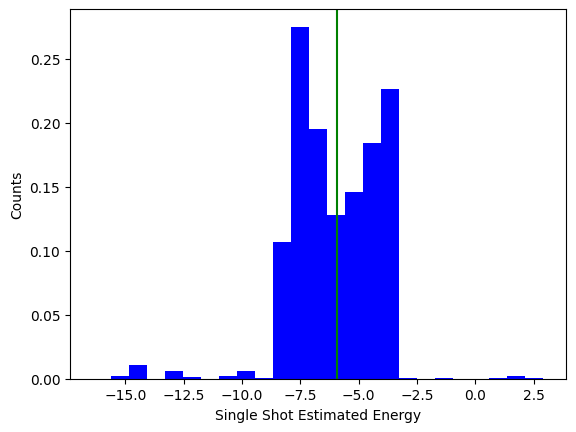

In [5]:
distr = distrfinder(V,W,nua,nub,'test_dest')

mean=sum(distr)/len(distr)
standard_error=np.std(distr)/np.sqrt(shots)
print(f'\nThe known energy value is {np.round(targ_val,4)} while we estimated {np.round(mean,4)}')
print(f'The relative error is {abs(np.round(100*(mean-targ_val)/targ_val,1))}%\n')
# We define bin width as bin_width= 4 * (max(distr) - min(distr)) / np.sqrt(shots)
plt.hist(distr, density=True, bins=int(np.sqrt(shots)/4), color='b', label='Single Shot Energy Distribution')  # density=False would make counts
plt.ylabel('Counts')
plt.axvline(x = targ_val, color = 'g', label = 'calculated_expectation_value')
plt.xlabel('Single Shot Estimated Energy')
plt.show()

Now we have all of our data and can proceed to analyzing it.